### TeamName: 500 days of training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing all the csv as dataframes

ride_ids = pd.read_csv("./ride_ids.csv")
driver_ids = pd.read_csv("./driver_ids.csv")
driver_timestamps = pd.read_csv("./ride_timestamps.csv")

# Questions asked and their progress
1. Number of rides - Cumulative - In Progress
2. Number of rides each day - In Progress
3. Time for the first ride from onboard - Not started
4.  Time at which rides were taken - More exploratory related to the timings - Data Curated
5. (What is ride prime time and questions around that) - Surcharge.. cost of a ride changed according to prime time
6. Questions around distance- More exploratory
7. Percentage of prime time in the ride (Cumulative percentage etc) - Done
8. Time between accepting the ride and the arriving .- Done w.r.t data. Need to explore
9. Travel time - More exploratory
10. Compute value of a ride - Done
11. Span Of work each day - Incomplete (Time between the first ride of the day and the last ride of the day) - Median work hours each day, Mean
12. Days with no ride - Incomplete

In [3]:
# Supporting functions

def costOfTrip(dist, time, prime_time):
    service_charge = 1.75
    base_cost = 2
    cost_by_dist = (dist* 0.000621371) * 1.15
    cost_by_time = time * (0.22/60)
    cost_prime_time = prime_time * (0.22/60)
    total_cost = service_charge + base_cost + cost_by_dist + cost_by_time + cost_prime_time
    if total_cost < 5:
        return 5
    if total_cost > 400:
        return 400
    return total_cost


In [4]:
ride_ids["trip_cost"] = ride_ids.apply(lambda x: costOfTrip(x["ride_distance"], x["ride_duration"], x["ride_prime_time"]), axis=1)


In [5]:
total_trips = ride_ids.groupby('driver_id').size().reset_index(drop=False)
total_trips.columns = ["driver_id", "total_trips"]
grp_sum = ride_ids.groupby('driver_id').cumsum().set_index(ride_ids.driver_id).reset_index(drop=True)
grp_sum.columns = ["cumulative_ride_distance", "cumulative_ride_duration", "cumulative_ride_prime_time", "cumulative_trip_cost"]

In [6]:
ride_ids[grp_sum.columns] = grp_sum

In [7]:
ride_ids.tail()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,trip_cost,cumulative_ride_distance,cumulative_ride_duration,cumulative_ride_prime_time,cumulative_trip_cost
193497,ffff51a71f2f185ec5e97d59dbcd7a78,fc717192b3512767269ff5a54b97af05,10127,1336,0,15.885184,2357560,265655,6525,3906.194906
193498,ffff51a71f2f185ec5e97d59dbcd7a78,fd6fa5f9265d2cf83936ead663f9e0e7,1908,445,0,6.745079,2359468,266100,6525,3912.939985
193499,ffff51a71f2f185ec5e97d59dbcd7a78,fe0857c43025264d337dfe1d8463e503,4039,875,0,9.844508,2363507,266975,6525,3922.784493
193500,ffff51a71f2f185ec5e97d59dbcd7a78,ff0db0ca4557bf5b05b4da6f660a1ac1,4760,777,0,10.000385,2368267,267752,6525,3932.784878
193501,ffff51a71f2f185ec5e97d59dbcd7a78,ff7dc29693f8c79ff103d350a7b6c157,3751,889,100,10.056710,2372018,268641,6625,3942.841588


In [8]:
ride_ids = ride_ids.merge(total_trips, on="driver_id", how="inner").reset_index(drop=True)

In [9]:
ride_ids.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,trip_cost,cumulative_ride_distance,cumulative_ride_duration,cumulative_ride_prime_time,cumulative_trip_cost,total_trips
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,6.426432,1811,327,50,6.426432,277
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,9.118740,5173,1136,50,15.545172,277
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,8.192574,8455,1708,50,23.737746,277
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,62.730707,73738,5046,75,86.468453,277
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,10.074816,77853,5869,175,96.543269,277


In [10]:
driver_ids["driver_onboard_date"] = pd.to_datetime(driver_ids["driver_onboard_date"])
driver_timestamps["timestamp"] = pd.to_datetime(driver_timestamps["timestamp"])

In [13]:
driver_ids["driver_onboard_date"] = driver_ids["driver_onboard_date"].apply(lambda x: x.tz_localize('US/Pacific'))
driver_timestamps["timestamp"] = driver_timestamps["timestamp"].apply(lambda x: x.tz_localize('US/Pacific'))

In [14]:
#driver_timestamps = driver_timestamps.assign(
    #timediff = driver_timestamps.sort_values('timestamp', ascending=False).groupby("ride_id").timestamp.diff(-1).dt.seconds.fillna(0)
#)

# This approach didnt work because some of the times werent in order between the events for a ride 

In [14]:
df_pivot = driver_timestamps.pivot(index="ride_id", columns="event")
driver_timestamps = pd.DataFrame(df_pivot.to_records())
driver_timestamps.columns = ["ride_id", "accepted_at_time", "arrived_at_time", "dropped_off_time", "picked_up_time", "requested_at_time"]

In [45]:
driver_timestamps["arrived_at_time"][0]

Timestamp('2016-06-13 16:44:31')

In [15]:
driver_timestamps.columns = ["ride_id", "accepted_at_time", "arrived_at_time", "dropped_off_time", "picked_up_time", "requested_at_time"]
driver_timestamps["time_to_accept"] = (driver_timestamps["accepted_at_time"] - driver_timestamps["requested_at_time"]).dt.seconds.fillna(0)
driver_timestamps["time_to_arrive"] = (driver_timestamps["arrived_at_time"] - driver_timestamps["accepted_at_time"]).dt.seconds.fillna(0)
driver_timestamps["time_for_customer_to_arrive"] = (driver_timestamps["picked_up_time"] - driver_timestamps["arrived_at_time"]).dt.seconds.fillna(0)

In [16]:
# Merge the dataframes , to get one master dataframe.
merged_intermediate = ride_ids.merge(driver_ids, on="driver_id", how="outer")
full_df = merged_intermediate.merge(driver_timestamps, on="ride_id", how="outer")

In [17]:
# Inferences
# There are 83 drivers who dont have a ride (in driver_id dataframe but not in ride_ids)
# There are 83 drivers who dont have onboard date (in ride_id df but not in driver_id)


In [18]:
full_df.isna().apply(lambda x: sum(x))

driver_id                       9262
ride_id                           83
ride_distance                   9345
ride_duration                   9345
ride_prime_time                 9345
trip_cost                       9345
cumulative_ride_distance        9345
cumulative_ride_duration        9345
cumulative_ride_prime_time      9345
cumulative_trip_cost            9345
total_trips                     9345
driver_onboard_date            16873
accepted_at_time                8766
arrived_at_time                 8767
dropped_off_time                8766
picked_up_time                  8766
requested_at_time               8766
time_to_accept                  8766
time_to_arrive                  8766
time_for_customer_to_arrive     8766
dtype: int64

In [25]:
# Get the difference from onboard time to the last ride time

last_ride_in_df = max(full_df["accepted_at_time"]).tz_localize('US/Pacific')

In [27]:
full_df["time_at_lyft"] = (last_ride_in_df-full_df["driver_onboard_date"]).dt.days

In [28]:
max(full_df["time_at_lyft"])

91.0

In [29]:
min(full_df["time_at_lyft"])

43.0

In [30]:
no_onboard_date_drivers = list(set(ride_ids.driver_id.unique()).difference(set(driver_ids.driver_id.unique())))

In [31]:
no_ride_drivers = list(set(driver_ids.driver_id.unique()).difference(set(ride_ids.driver_id.unique())))

In [32]:
len(no_onboard_date_drivers)

83

In [33]:
full_df["prime_time_percent"] = full_df["ride_prime_time"] / full_df["ride_duration"]

In [34]:
grouped_full = full_df.groupby('driver_id').agg({"mean", "median", "sum", "size"})

In [35]:
grouped_full.columns =grouped_full.columns.map('.'.join).str.strip('.')

In [36]:
grouped_full = grouped_full.reset_index(drop=False)

In [37]:
grouped_full.columns

Index(['driver_id', 'ride_distance.mean', 'ride_distance.size',
       'ride_distance.median', 'ride_distance.sum', 'ride_duration.mean',
       'ride_duration.size', 'ride_duration.median', 'ride_duration.sum',
       'ride_prime_time.mean', 'ride_prime_time.size',
       'ride_prime_time.median', 'ride_prime_time.sum', 'trip_cost.mean',
       'trip_cost.size', 'trip_cost.median', 'trip_cost.sum',
       'cumulative_ride_distance.mean', 'cumulative_ride_distance.size',
       'cumulative_ride_distance.median', 'cumulative_ride_distance.sum',
       'cumulative_ride_duration.mean', 'cumulative_ride_duration.size',
       'cumulative_ride_duration.median', 'cumulative_ride_duration.sum',
       'cumulative_ride_prime_time.mean', 'cumulative_ride_prime_time.size',
       'cumulative_ride_prime_time.median', 'cumulative_ride_prime_time.sum',
       'cumulative_trip_cost.mean', 'cumulative_trip_cost.size',
       'cumulative_trip_cost.median', 'cumulative_trip_cost.sum',
       'total_tri

In [38]:
grouped_full.head()

,driver_id,ride_distance.mean,ride_distance.size,ride_distance.median,ride_distance.sum,ride_duration.mean,ride_duration.size,ride_duration.median,ride_duration.sum,ride_prime_time.mean,...,time_for_customer_to_arrive.median,time_for_customer_to_arrive.sum,time_at_lyft.mean,time_at_lyft.size,time_at_lyft.median,time_at_lyft.sum,prime_time_percent.mean,prime_time_percent.size,prime_time_percent.median,prime_time_percent.sum
0,002be0ffdc997bd5c50703158b7c2491,6282.624549,277,3800.0,1740287.0,798.693141,277,714.0,221238.0,19.404332,...,3.0,951849.0,90.0,277,90.0,24930.0,0.033861,277,0.0,9.379531
1,007f0389f9c7b03ef97098422f902e62,3791.322581,31,3444.0,117531.0,661.193548,31,611.0,20497.0,20.161290,...,3.0,172951.0,90.0,31,90.0,2790.0,0.036470,31,0.0,1.130584
2,011e5c5dfc5c2c92501b8b24d47509bc,7930.970588,34,4567.0,269653.0,858.970588,34,759.5,29205.0,19.852941,...,2.0,172939.0,83.0,34,83.0,2822.0,0.031805,34,0.0,1.081357
3,0152a2f305e71d26cc964f8d4411add9,7702.821990,191,5793.0,1471239.0,913.722513,191,779.0,174521.0,10.732984,...,4.0,778653.0,65.0,191,65.0,12415.0,0.014150,191,0.0,2.702722
4,01674381af7edd264113d4e6ed55ecda,8329.717333,375,4724.0,3123644.0,953.181333,375,851.0,357443.0,12.533333,...,3.0,1299078.0,59.0,375,59.0,22125.0,0.019178,375,0.0,7.191729


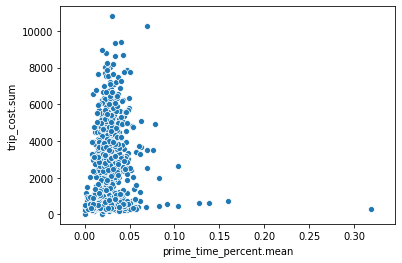

In [39]:
# Duration vs Price Model to figure out the outliers

sns.scatterplot(data=grouped_full, x="prime_time_percent.mean", y="trip_cost.sum")

In [40]:
average_rider_earnings = grouped_full["trip_cost.sum"].mean()

In [41]:
grouped_full["earnings_type"] = grouped_full["trip_cost.sum"].apply(lambda x: "more_than_average" if x > average_rider_earnings else "less_than_average")

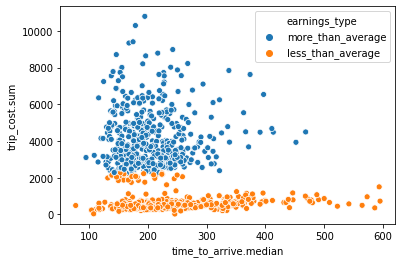

In [42]:
sns.scatterplot(data=grouped_full, y="trip_cost.sum", x="time_to_arrive.median", hue="earnings_type")

In [43]:
grouped_full.columns

Index(['driver_id', 'ride_distance.mean', 'ride_distance.size',
       'ride_distance.median', 'ride_distance.sum', 'ride_duration.mean',
       'ride_duration.size', 'ride_duration.median', 'ride_duration.sum',
       'ride_prime_time.mean', 'ride_prime_time.size',
       'ride_prime_time.median', 'ride_prime_time.sum', 'trip_cost.mean',
       'trip_cost.size', 'trip_cost.median', 'trip_cost.sum',
       'cumulative_ride_distance.mean', 'cumulative_ride_distance.size',
       'cumulative_ride_distance.median', 'cumulative_ride_distance.sum',
       'cumulative_ride_duration.mean', 'cumulative_ride_duration.size',
       'cumulative_ride_duration.median', 'cumulative_ride_duration.sum',
       'cumulative_ride_prime_time.mean', 'cumulative_ride_prime_time.size',
       'cumulative_ride_prime_time.median', 'cumulative_ride_prime_time.sum',
       'cumulative_trip_cost.mean', 'cumulative_trip_cost.size',
       'cumulative_trip_cost.median', 'cumulative_trip_cost.sum',
       'total_tri

In [65]:
full_df["time_of_day"] = full_df.apply(lambda x: timeOfDay(x["picked_up_time"].tz_localize('US/Pacific')), axis=1)

In [59]:
def timeOfDay(ts):
    hour = ts.hour
    if (hour >= 0) and (hour<5):
        return "ODD_TIME"
    if (hour >= 5) and (hour < 9):
        return "MORNING"
    if (hour >= 9) and (hour < 12):
        return "LATE_MORNING"
    if (hour >= 12) and (hour < 15):
        return "AFTERNOON"
    if (hour >= 15) and (hour < 18):
        return "EVENING"
    if (hour >= 18) and (hour < 21):
        return "NIGHT"
    if (hour >= 21) and (hour < 24):
        return "LATE_NIGHT"

#0 - 5 Odd time
# 5-9 Morning
# 9 -12
# 12 -3 # Afternoon
# 3 -6 Late afternoon
# 6 - 9 Night
# 9 - 12 Late Night

In [64]:
time_of_day.value_counts()

ODD_TIME        65210
MORNING         33463
EVENING         27410
LATE_NIGHT      26288
NIGHT           24440
AFTERNOON       11623
LATE_MORNING     5647
dtype: int64

In [76]:
full_df["month"] = full_df["picked_up_time"].apply(lambda x: x.month)
full_df["day"] = full_df["picked_up_time"].apply(lambda x: x.day)

In [79]:
def is_weekend_rush(ts, time_of_day):
    wkd = ts.weekday()
    hr = ts.hour
    if (wkd >= 5 ) or (wkd == 4 and time_of_day == "NIGHT") or (wkd == 4 and time_of_day == "LATE_NIGHT"):
        return True
    else:
        return False

In [80]:
full_df["is_weekend_rush"] = full_df.apply(lambda x: is_weekend_rush(x["picked_up_time"], x["time_of_day"]), axis=1)

In [81]:
full_df["is_weekend_rush"].value_counts()

False    129463
True      73384
Name: is_weekend_rush, dtype: int64

In [88]:
full_df.groupby('day').plot(legend=True)

/home/mancunian92/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])
/home/mancunian92/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


day
1.0     AxesSubplot(0.125,0.125;0.775x0.755)
2.0     AxesSubplot(0.125,0.125;0.775x0.755)
3.0     AxesSubplot(0.125,0.125;0.775x0.755)
4.0     AxesSubplot(0.125,0.125;0.775x0.755)
5.0     AxesSubplot(0.125,0.125;0.775x0.755)
6.0     AxesSubplot(0.125,0.125;0.775x0.755)
7.0     AxesSubplot(0.125,0.125;0.775x0.755)
8.0     AxesSubplot(0.125,0.125;0.775x0.755)
9.0     AxesSubplot(0.125,0.125;0.775x0.755)
10.0    AxesSubplot(0.125,0.125;0.775x0.755)
11.0    AxesSubplot(0.125,0.125;0.775x0.755)
12.0    AxesSubplot(0.125,0.125;0.775x0.755)
13.0    AxesSubplot(0.125,0.125;0.775x0.755)
14.0    AxesSubplot(0.125,0.125;0.775x0.755)
15.0    AxesSubplot(0.125,0.125;0.775x0.755)
16.0    AxesSubplot(0.125,0.125;0.775x0.755)
17.0    AxesSubplot(0.125,0.125;0.775x0.755)
18.0    AxesSubplot(0.125,0.125;0.775x0.755)
19.0    AxesSubplot(0.125,0.125;0.775x0.755)
20.0    AxesSubplot(0.125,0.125;0.775x0.755)
21.0    AxesSubplot(0.125,0.125;0.775x0.755)
22.0    AxesSubplot(0.125,0.125;0.775x0.755)
23.0  

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fb3f7ad0730> (for post_execute):


ValueError: view limit minimum -323424.95 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -323424.95 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -329185.85000000003 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -305881.05 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -315946.75 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -316695.7 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -303817.9 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -327111.7 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -304163.3 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -314172.2 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -322080.60000000003 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -317450.85000000003 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -307951.2 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -310395.35000000003 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -330087.25 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -308075.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -317721.05000000005 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -331301.25 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -319116.9 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -317363.05000000005 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -329805.05000000005 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -318905.05000000005 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -329843.05000000005 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -310149.2 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -313959.05 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -317660.80000000005 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -324506.25 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -327347.9 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -331410.05000000005 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -313797.8 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -309018.60000000003 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

ValueError: view limit minimum -317284.95 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

In [95]:
full_df["day_name"] = full_df["picked_up_time"].apply(lambda x: x.day_name())

In [96]:
full_df.shape

(202847, 27)

In [92]:
full_df["picked_up_time"][0].day_name()

'Saturday'

In [97]:
full_df["day_name"].value_counts()

Saturday     32882
Sunday       32205
Friday       31068
Thursday     27967
Wednesday    26402
Tuesday      23199
Monday       20358
Name: day_name, dtype: int64

In [99]:
grouped_full = full_df.groupby("driver_id").agg({"mean", "median", "sum", "size"})
grouped_full.columns =grouped_full.columns.map('.'.join).str.strip('.')
grouped_full = grouped_full.reset_index(drop=False)

In [100]:
grouped_full.head()

,driver_id,ride_distance.mean,ride_distance.size,ride_distance.median,ride_distance.sum,ride_duration.mean,ride_duration.size,ride_duration.median,ride_duration.sum,ride_prime_time.mean,...,month.median,month.sum,day.mean,day.size,day.median,day.sum,is_weekend_rush.mean,is_weekend_rush.size,is_weekend_rush.median,is_weekend_rush.sum
0,002be0ffdc997bd5c50703158b7c2491,6282.624549,277,3800.0,1740287.0,798.693141,277,714.0,221238.0,19.404332,...,5.0,1379.0,13.610108,277,14.0,3770.0,0.335740,277,0.0,93.0
1,007f0389f9c7b03ef97098422f902e62,3791.322581,31,3444.0,117531.0,661.193548,31,611.0,20497.0,20.161290,...,5.0,150.0,18.258065,31,19.0,566.0,0.354839,31,0.0,11.0
2,011e5c5dfc5c2c92501b8b24d47509bc,7930.970588,34,4567.0,269653.0,858.970588,34,759.5,29205.0,19.852941,...,5.0,163.0,14.823529,34,14.0,504.0,0.117647,34,0.0,4.0
3,0152a2f305e71d26cc964f8d4411add9,7702.821990,191,5793.0,1471239.0,913.722513,191,779.0,174521.0,10.732984,...,6.0,1039.0,17.235602,191,17.0,3292.0,0.267016,191,0.0,51.0
4,01674381af7edd264113d4e6ed55ecda,8329.717333,375,4724.0,3123644.0,953.181333,375,851.0,357443.0,12.533333,...,5.0,2047.0,14.410667,375,14.0,5404.0,0.088000,375,0.0,33.0


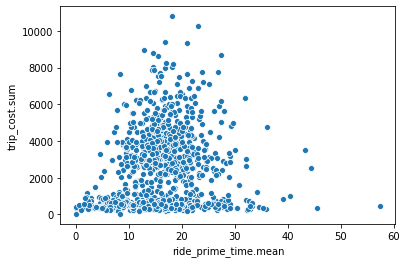

In [110]:
sns.scatterplot(data=grouped_full, x="is_weeke")

In [172]:
grouped_filtered = grouped_full[grouped_full["driver_id"].isin(no_ride_drivers) == False]

In [173]:
grouped_filtered.shape

(937, 71)

In [117]:
grouped_full["earnings_per_day"] = grouped_full["trip_cost.sum"]/grouped_full["time_at_lyft.mean"]

In [159]:
grouped_full["avg_rides_per_day"] = grouped_full["day.size"]/grouped_full["time_at_lyft.mean"]

In [207]:
def earningType(x, avgEarning):
    if x > (1.5 * avgEarning):
        return "OverAcheiver"
    elif x > avgEarning:
        return "AboveAverage"
    elif x < (avgEarning - (0.5 * avgEarning)):
        return "UnderAcheiver"
    elif x < avgEarning:
        return "BelowAverage"

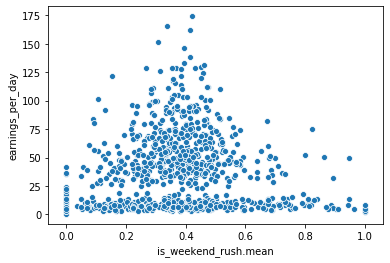

In [208]:
sns.scatterplot(data=grouped_filtered, x="is_weekend_rush.mean", y="earnings_per_day")

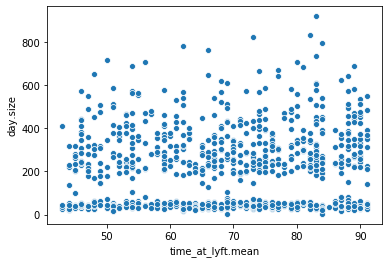

In [121]:
sns.scatterplot(data=grouped_filtered, x="time_at_lyft.mean", y="day.size")

In [209]:
median_earning = grouped_filtered["trip_cost.sum"].median()
avg_earning = grouped_filtered["trip_cost.sum"].mean()
grouped_filtered["median_cut_off_earning"] = grouped_filtered["trip_cost.sum"].apply(lambda x: earningType(x, median_earning))
grouped_filtered["mean_cut_off_earning"] = grouped_filtered["trip_cost.sum"].apply(lambda x: earningType(x, avg_earning))


/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [231]:
passive_riders = grouped_filtered[grouped_filtered["avg_rides_per_day"] < 2]["driver_id"]

In [232]:
passive_riders.shape

(350,)

In [233]:
active_riders = grouped_filtered[grouped_filtered.driver_id.isin(passive_riders) == False]

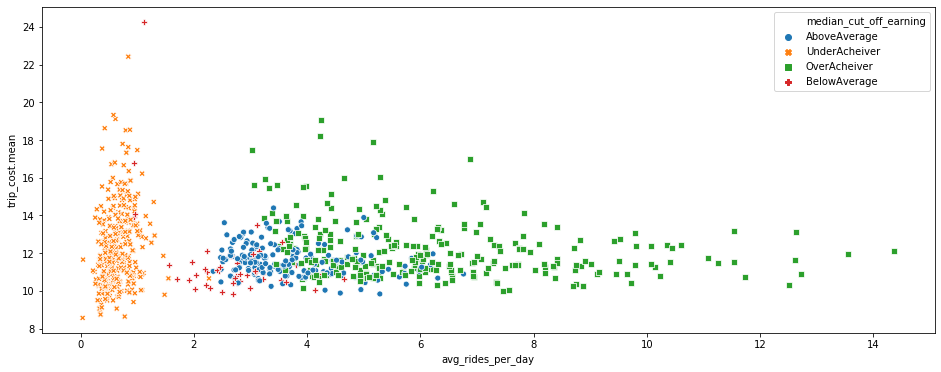

In [243]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=grouped_filtered, x="avg_rides_per_day", y="trip_cost.mean", style="median_cut_off_earning", hue="median_cut_off_earning")

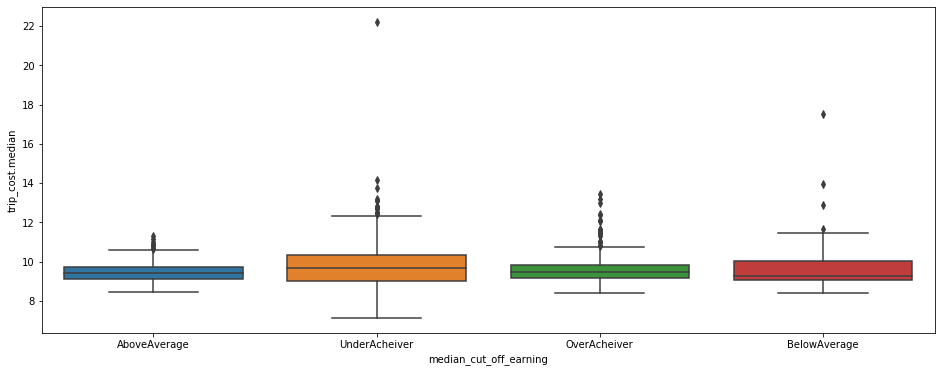

In [246]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="trip_cost.median")

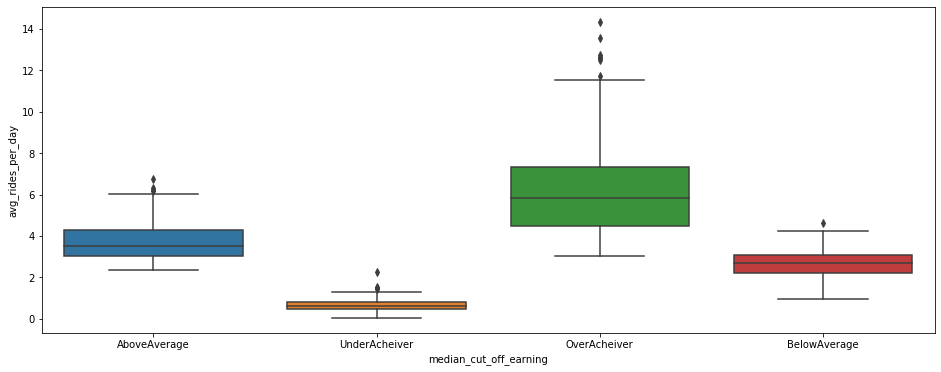

In [247]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="avg_rides_per_day")

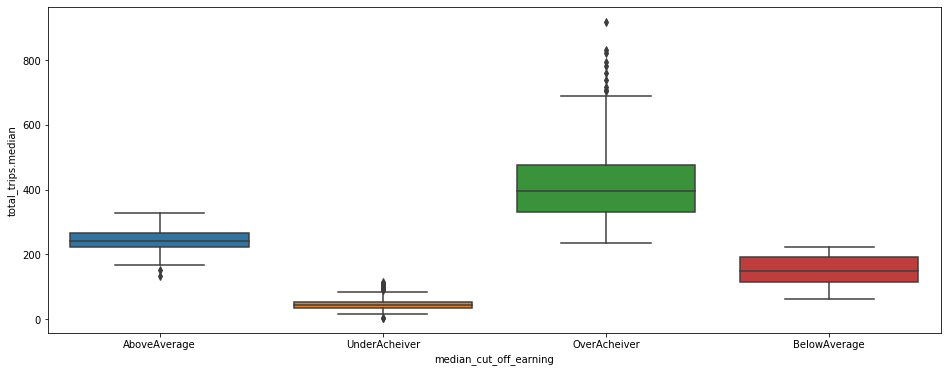

In [256]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="total_trips.median")

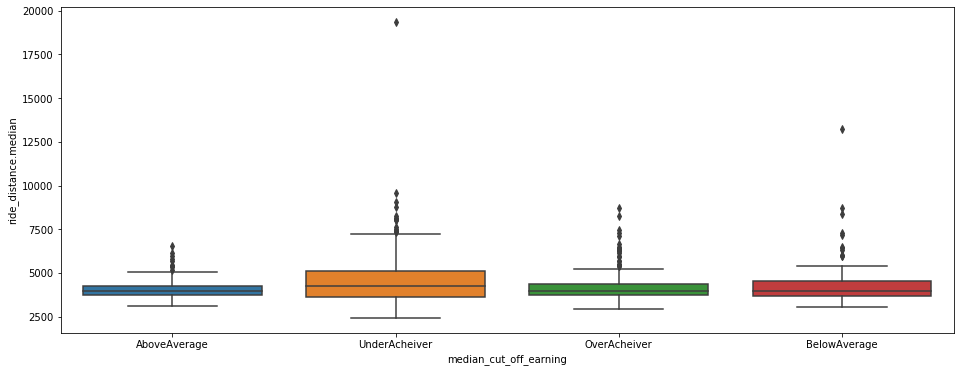

In [262]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="ride_distance.median")

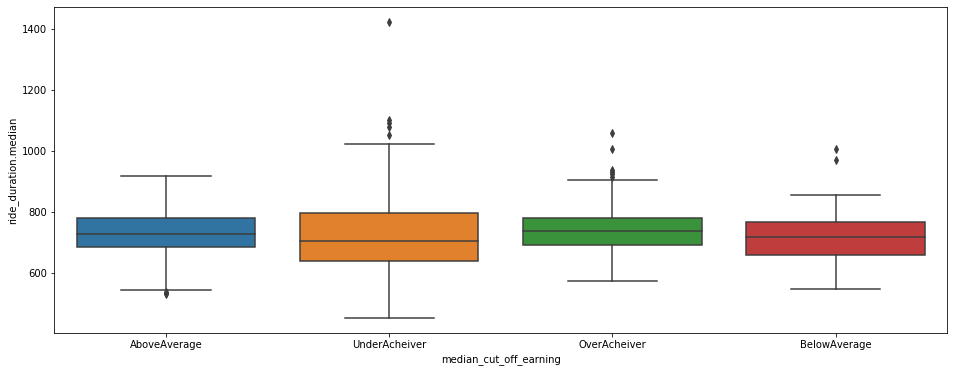

In [265]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="ride_duration.median")

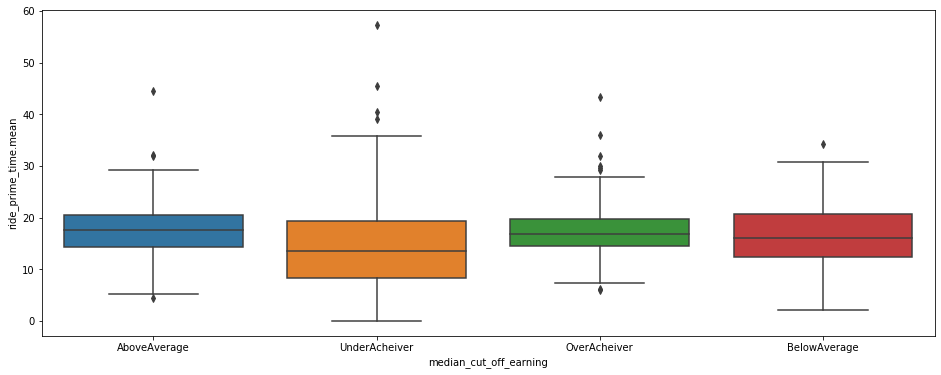

In [267]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="ride_prime_time.mean")

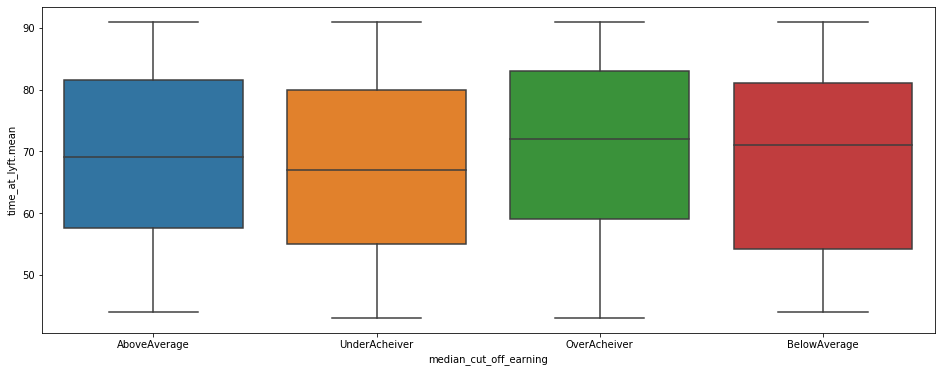

In [270]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="time_at_lyft.mean")

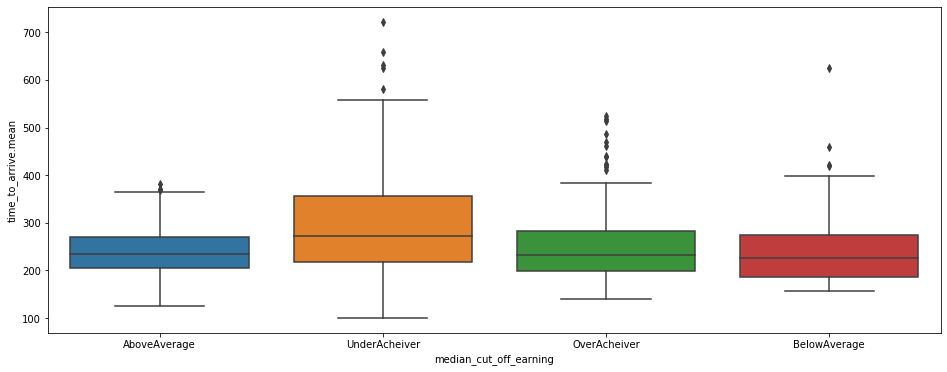

In [271]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="time_to_arrive.mean")

In [215]:
median_earning

2287.137490039199

In [216]:
avg_earning

2465.165132499584

In [217]:
grouped_filtered["median_cut_off_earning"].value_counts()

UnderAcheiver    391
OverAcheiver     282
AboveAverage     186
BelowAverage      77
Name: median_cut_off_earning, dtype: int64

In [272]:
underacheived = grouped_filtered[grouped_filtered["median_cut_off_earning"]=="UnderAcheiver"]

In [273]:
underacheived.shape

(391, 73)

In [313]:
below = grouped_filtered[grouped_filtered["trip_cost.sum"] < median_earning]
above = grouped_filtered[grouped_filtered["trip_cost.sum"] > median_earning]
overacheive_less_duration = above[(above["time_at_lyft.mean"] < 50) & (above["median_cut_off_earning"]=="OverAcheiver")]
below_average_more_duration = below[(below["time_at_lyft.mean"] >= 50) & (below["median_cut_off_earning"]=="BelowAverage")]

In [314]:
overacheive_less_duration.shape

(23, 73)

In [315]:
below_average_more_duration.shape

(37, 73)

In [316]:
combined = pd.concat([overacheive_less_duration,below_average_more_duration])
# Now remove off the passive riders
combined = combined[combined.driver_id.isin(passive_riders)==False]

In [317]:
combined["median_cut_off_earning"].value_counts()

BelowAverage    28
OverAcheiver    23
Name: median_cut_off_earning, dtype: int64

In [320]:
list(combined.columns)

['driver_id',
 'ride_distance.mean',
 'ride_distance.size',
 'ride_distance.median',
 'ride_distance.sum',
 'ride_duration.mean',
 'ride_duration.size',
 'ride_duration.median',
 'ride_duration.sum',
 'ride_prime_time.mean',
 'ride_prime_time.size',
 'ride_prime_time.median',
 'ride_prime_time.sum',
 'trip_cost.mean',
 'trip_cost.size',
 'trip_cost.median',
 'trip_cost.sum',
 'cumulative_ride_distance.mean',
 'cumulative_ride_distance.size',
 'cumulative_ride_distance.median',
 'cumulative_ride_distance.sum',
 'cumulative_ride_duration.mean',
 'cumulative_ride_duration.size',
 'cumulative_ride_duration.median',
 'cumulative_ride_duration.sum',
 'cumulative_ride_prime_time.mean',
 'cumulative_ride_prime_time.size',
 'cumulative_ride_prime_time.median',
 'cumulative_ride_prime_time.sum',
 'cumulative_trip_cost.mean',
 'cumulative_trip_cost.size',
 'cumulative_trip_cost.median',
 'cumulative_trip_cost.sum',
 'total_trips.mean',
 'total_trips.size',
 'total_trips.median',
 'total_trips.sum

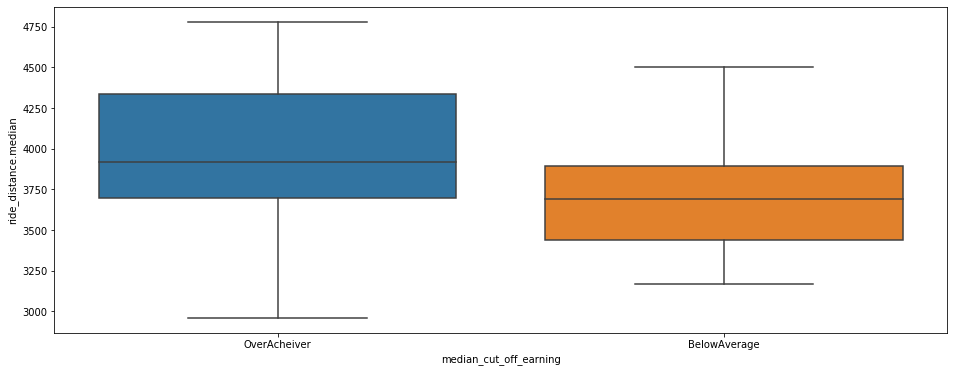

In [327]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=combined, x="median_cut_off_earning", y="ride_distance.median")

In [328]:
## Taking longer trips instead of shorter trips

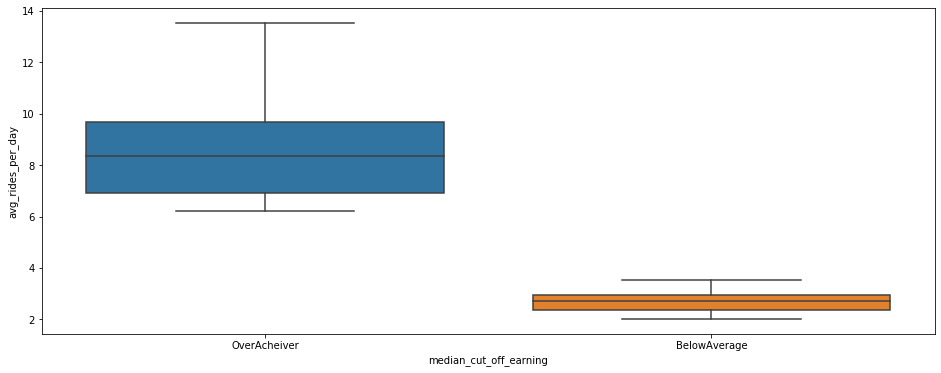

In [326]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=combined, x="median_cut_off_earning", y="avg_rides_per_day")

In [132]:
below.shape

(468, 72)

In [133]:
below.isna().apply(lambda x: sum(x))

driver_id                  0
ride_distance.mean         0
ride_distance.size         0
ride_distance.median       0
ride_distance.sum          0
                          ..
is_weekend_rush.median     0
is_weekend_rush.sum        0
earnings_per_day          80
median_cut_off_earning     0
mean_cut_off_earning       0
Length: 72, dtype: int64

In [135]:
below["time_at_lyft.mean"]

1       90.0
2       83.0
7       51.0
10      55.0
11      88.0
        ... 
1008    63.0
1012    90.0
1013     NaN
1015     NaN
1017    80.0
Name: time_at_lyft.mean, Length: 468, dtype: float64

In [127]:
min(full_df["picked_up_time"])

Timestamp('2016-03-28 13:02:39')

In [128]:
max(full_df["picked_up_time"])

Timestamp('2016-06-27 07:02:06')

In [129]:
min(full_df["driver_onboard_date"])

Timestamp('2016-03-28 00:00:00-0700', tz='US/Pacific')

In [130]:
max(full_df["driver_onboard_date"])

Timestamp('2016-05-15 00:00:00-0700', tz='US/Pacific')